Word2vec Embedding

https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953

https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/

https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229

In [2]:
import re, string 
import pandas as pd 
import numpy as np
from time import time  
import re, itertools, random
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
#STOPWORDS.extend(['from', 'subject', 're', 'edu', 'use','user', 'com', 'co', 'con', 'be', 'else', 'http', 'would','send', 
                   'do','tell', 'go', 'get', 'can', 'give', 'mr.', 'next', 'find', 'Do', 'Not'])
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from scipy.spatial.distance import cdist
nlp_spacy = spacy.load('en_md', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
#nlp_ginsem = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) #for Gensim pretrained model
#from gensim.models import KeyedVectors #for Gensim pretrained model

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return ' '.join(word for word in text.split() if word not in STOPWORDS)

def lemmatizer_spacy(text):        
    sent = []
    doc = nlp_spacy(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

def lemmatizer_gensim(text):        
    sent = []
    doc = nlp_gensim(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [4]:
cdf = pd.read_csv('cdf.csv')
df = cdf.drop(cdf[(cdf.PM == 'none')].index)
df = df[['MONTH_INT', 'TEXT', 'PM']]

In [5]:
df.head()

,MONTH_INT,TEXT,PM
7,7,Nicola Sturgeon tells Boris Johnson: Brexit of...,Boris Johnson
9,7,If we ever get brexit.and Boris is looking mor...,Boris Johnson
12,7,Media have finally realised that Brexit will b...,Boris Johnson
22,7,@BorisJohnson this better be a joke or else yo...,Boris Johnson
24,7,"""Turbo-charge"" Brexit plans, with ""all necessa...",Boris Johnson


In [6]:
df.shape

(30143, 3)

In [22]:
df_march = df[df['MONTH_INT'] == 3]
df_july = df[df['MONTH_INT'] == 7]
df_nov = df[df['MONTH_INT'] == 11]

### Preparing the data

In [7]:
df['TEXT'] = df.TEXT.apply(lambda x: clean_text(x))

In [23]:
df_march['TEXT'] = df_march.TEXT.apply(lambda x: clean_text(x))
df_july['TEXT'] = df_july.TEXT.apply(lambda x: clean_text(x))
df_nov['TEXT'] = df_nov.TEXT.apply(lambda x: clean_text(x))

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

## Choosing which pre train model to use: Spacy or Gensim

Spacy is a natural language processing (NLP) library for Python designed to have fast performance, and with word embedding models built in, it’s perfect for a quick and easy start.

Gensim is a topic modelling library for Python that provides access to Word2Vec and other word embedding algorithms for training, and it also allows pre-trained word embeddings that you can download from the internet to be loaded.

### Using pre-trained model from Spacy

In [8]:
nlp_spacy = spacy.load('en', disable=['ner', 'parser']) #disabling Named Entity Recognition for speed

df["TEXT_SPACY"] =  df.apply(lambda x: lemmatizer_spacy(x['TEXT']), axis=1)

In [9]:
df['TEXT_SPACY'] = df['TEXT_SPACY'].str.replace('-PRON-', '')   #removing pronouns

In [10]:
words_spacy = [row.split() for row in df["TEXT_SPACY"]]
word_freq_spacy = defaultdict(int)
for sent in words_spacy:
    for i in sent:
        word_freq_spacy[i] += 1
sorted(word_freq_spacy, key = word_freq_spacy.get, reverse=True)[:10]

['brexit',
 'boris',
 'theresa',
 'may',
 'johnson',
 '-PRON-',
 'deal',
 'not',
 'vote',
 'do']

In [24]:
df_march["TEXT_SPACY"] =  df_march.apply(lambda x: lemmatizer_spacy(x['TEXT']), axis=1)
df_july["TEXT_SPACY"] =  df_july.apply(lambda x: lemmatizer_spacy(x['TEXT']), axis=1)
df_nov["TEXT_SPACY"] =  df_nov.apply(lambda x: lemmatizer_spacy(x['TEXT']), axis=1)
df_march['TEXT_SPACY'] = df_march['TEXT_SPACY'].str.replace('-PRON-', '')   #removing pronouns
df_july['TEXT_SPACY'] = df_july['TEXT_SPACY'].str.replace('-PRON-', '')   #removing pronouns
df_nov['TEXT_SPACY'] = df_nov['TEXT_SPACY'].str.replace('-PRON-', '')   #removing pronouns

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [29]:
words_spacy_march = [row.split() for row in df_march["TEXT_SPACY"]]
word_freq_spacy_march = defaultdict(int)
for sent in words_spacy:
    for i in sent:
        word_freq_spacy_march[i] += 1
sorted(word_freq_spacy_march, key = word_freq_spacy_march.get, reverse=True)[:10]

['brexit',
 'boris',
 'johnson',
 'not',
 'deal',
 'vote',
 'do',
 'party',
 'tory',
 'want']

In [31]:
words_spacy_july = [row.split() for row in df_july["TEXT_SPACY"]]
word_freq_spacy_july = defaultdict(int)
for sent in words_spacy_july:
    for i in sent:
        word_freq_spacy_july[i] += 1
sorted(word_freq_spacy_july, key = word_freq_spacy_july.get, reverse=True)[:10]

['brexit',
 'boris',
 'johnson',
 'not',
 'deal',
 'borisjohnson',
 'do',
 'eu',
 'uk',
 'may']

In [34]:
words_spacy_nov = [row.split() for row in df_nov["TEXT_SPACY"]]
word_freq_spacy_nov = defaultdict(int)
for sent in words_spacy_nov:
    for i in sent:
        word_freq_spacy_nov[i] += 1
sorted(word_freq_spacy_nov, key = word_freq_spacy_nov.get, reverse=True)[:10]

['brexit',
 'boris',
 'johnson',
 'not',
 'deal',
 'vote',
 'do',
 'party',
 'tory',
 'want']

# IGNORE - Tried with gensim library

In [ ]:
from gensim.models.phrases import Phrases, Phraser
import pandas as pd

from pprint import pprint

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','user', 'com', 'co', 'con', 'be', 'else', 'http', 'would','send', 
                   'do', 'try', 'tell', 'go', 'get', 'can', 'think', 'know', 'give', 'ask', 
               'next', 'find'])

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
df_tm = df['TEXT'].tolist()

In [ ]:
bigram = gensim.models.Phrases(df_tm, min_count=1, threshold=1) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
#remove Stop Words
data_words_nostops = remove_stopwords(df_tm)
#creating bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

In [ ]:
# Create Dictionary from the unique bigrams 
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=10)#, no_above=0.5) #excluding tokens that ocurred in less than 10 tweets and bigrams that occurred in more than 50% of the tweets
# Rebuild corpus based on the dictionary
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
sent = [row.split() for row in df['TEXT']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
sentences = bigram[sent]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

#### Using pre-trained model from Gensim

In [ ]:
# Load vectors directly from the file
df["TEXT_GENSIM"] =  df.apply(lambda x: lemmatizer_gensim(x['TEXT']), axis=1)

In [ ]:
words_gensim = [row.split() for row in df["TEXT_GENSIM"]]
word_freq_gensim = defaultdict(int)
for sent in words_gensim:
    for i in sent:
        word_freq_gensim[i] += 1
sorted(word_freq_gensim, key = word_freq_gensim.get, reverse=True)[:10]

## IMPLEMENTING THE MODEL

### Initializing the model with Spacy

In [12]:
w2v_model = Word2Vec(min_count=100,
                     window=3,
                     size=200,
                     workers=4)

In [13]:
#building the vocabulary (from the tweets) for the model
w2v_model.build_vocab(words_spacy)

In [14]:
w2v_model.train(words_spacy, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


In [16]:
w2v_model.wv.vocab

{'tell': <gensim.models.keyedvectors.Vocab at 0x10fe4cf50>,
 'boris': <gensim.models.keyedvectors.Vocab at 0x10fe4cfd0>,
 'johnson': <gensim.models.keyedvectors.Vocab at 0x10fe4cd50>,
 'brexit': <gensim.models.keyedvectors.Vocab at 0x14494af10>,
 'offer': <gensim.models.keyedvectors.Vocab at 0x14494ad10>,
 'democracy': <gensim.models.keyedvectors.Vocab at 0x196540bd0>,
 'scotland': <gensim.models.keyedvectors.Vocab at 0x1965403d0>,
 'ever': <gensim.models.keyedvectors.Vocab at 0x12e7c0350>,
 'look': <gensim.models.keyedvectors.Vocab at 0x14494af90>,
 'day': <gensim.models.keyedvectors.Vocab at 0x196540d50>,
 'still': <gensim.models.keyedvectors.Vocab at 0x1449b0050>,
 'work': <gensim.models.keyedvectors.Vocab at 0x1449b0090>,
 'finally': <gensim.models.keyedvectors.Vocab at 0x1449b00d0>,
 'realise': <gensim.models.keyedvectors.Vocab at 0x1449b0110>,
 'disaster': <gensim.models.keyedvectors.Vocab at 0x1449b0150>,
 'borisjohnson': <gensim.models.keyedvectors.Vocab at 0x1449b0190>,
 'well

### Checking similarities

In [17]:
w2v_model.wv.most_similar(positive=['brexit'])

[('fail', 0.5419201850891113),
 ('unless', 0.48581641912460327),
 ('avoid', 0.45247381925582886),
 ('threat', 0.45206218957901),
 ('back', 0.44773560762405396),
 ('order', 0.4351575970649719),
 ('dup', 0.4351205825805664),
 ('rule', 0.43298476934432983),
 ('civil', 0.43214619159698486),
 ('meaningful', 0.431277871131897)]

In [18]:
w2v_model.wv.most_similar(positive=['boris'])

[('gove', 0.6558703184127808),
 ('mr', 0.6528462171554565),
 ('farage', 0.6085476875305176),
 ('admit', 0.5926600098609924),
 ('cameron', 0.5474148392677307),
 ('reesmogg', 0.5444197654724121),
 ('mogg', 0.5362565517425537),
 ('michael', 0.5333608388900757),
 ('raab', 0.5055277943611145),
 ('plan', 0.5052838325500488)]

In [19]:
w2v_model.wv.most_similar(positive=['theresa'])

[('consider', 0.5091501474380493),
 ('speech', 0.475283682346344),
 ('tomorrow', 0.4736223518848419),
 ('talk', 0.45646199584007263),
 ('cameron', 0.4460292160511017),
 ('dismiss', 0.4328914284706116),
 ('quit', 0.43278059363365173),
 ('face', 0.4327135682106018),
 ('delay', 0.4257791042327881),
 ('strategy', 0.42244046926498413)]

In [20]:
w2v_model.wv.similarity('brexit','theresa')

0.02133257

In [21]:
w2v_model.wv.similarity('brexit','boris')   

0.21456197

### Checking tweets from March only

In [38]:
w2v_model_march = Word2Vec(min_count=100,
                     window=3,
                     size=200,
                     workers=4)

In [39]:
#building the vocabulary (from the tweets) for the model
w2v_model_march.build_vocab(words_spacy_march)

In [40]:
w2v_model_march.train(words_spacy_march, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model_march.init_sims(replace=True)

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


In [45]:
w2v_model_march.wv.most_similar(positive=['brexit'])

[('mps', 0.9997859597206116),
 ('parliament', 0.9997690320014954),
 ('mays', 0.9997532367706299),
 ('time', 0.9997357130050659),
 ('bad', 0.9997342824935913),
 ('may', 0.9997243881225586),
 ('deal', 0.9997230768203735),
 ('make', 0.9997215270996094),
 ('say', 0.9997192621231079),
 ('let', 0.9997119903564453)]

In [43]:
w2v_model_march.wv.most_similar(positive=['theresa'])

[('deal', 0.9997092485427856),
 ('news', 0.9996671080589294),
 ('day', 0.9996660947799683),
 ('british', 0.9996592998504639),
 ('vote', 0.9996589422225952),
 ('eu', 0.999637246131897),
 ('theresamay', 0.9996336102485657),
 ('reject', 0.9996315240859985),
 ('’s', 0.9996270537376404),
 ('minister', 0.999621570110321)]

In [44]:
w2v_model_march.wv.most_similar(positive=['boris'])

[('see', 0.9998209476470947),
 ('lie', 0.9998131394386292),
 ('theresamay', 0.9998065829277039),
 ('country', 0.9998041987419128),
 ('pm', 0.9998040199279785),
 ('have', 0.9998033046722412),
 ('s', 0.9998032450675964),
 ('take', 0.9998018741607666),
 ('could', 0.999801516532898),
 ('party', 0.9998012781143188)]

### Checking tweets from July only

In [46]:
w2v_model_july = Word2Vec(min_count=100,
                     window=3,
                     size=200,
                     workers=4)
w2v_model_july.build_vocab(words_spacy_july)
w2v_model_july.train(words_spacy_july, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model_july.init_sims(replace=True)

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [47]:
w2v_model_july.wv.most_similar(positive=['brexit'])

[('’', 0.9998250007629395),
 ('deliver', 0.9998205900192261),
 ('one', 0.9998185634613037),
 ('vote', 0.9998182058334351),
 ('country', 0.9998180866241455),
 ('think', 0.9998146295547485),
 ('deal', 0.9998130798339844),
 ('boris', 0.9998112320899963),
 ('people', 0.9998095631599426),
 ('say', 0.9998061656951904)]

In [48]:
w2v_model_july.wv.most_similar(positive=['theresa'])

[('say', 0.9997798204421997),
 ('one', 0.9997712969779968),
 ('vote', 0.9997705221176147),
 ('deal', 0.9997687339782715),
 ('want', 0.9997603297233582),
 ('brexit', 0.9997565746307373),
 ('uk', 0.9997563362121582),
 ('s', 0.9997546672821045),
 ('tory', 0.9997535943984985),
 ('like', 0.9997485876083374)]

In [49]:
w2v_model_july.wv.most_similar(positive=['boris'])

[('say', 0.9998167753219604),
 ('take', 0.9998123049736023),
 ('brexit', 0.9998112320899963),
 ('deal', 0.9998093843460083),
 ('borisjohnson', 0.999808669090271),
 ('uk', 0.9998076558113098),
 ('not', 0.9998043775558472),
 ('new', 0.9998043179512024),
 ('johnson', 0.9998029470443726),
 ('vote', 0.9998015761375427)]

### Checking tweets from Nov only

In [50]:
w2v_model_nov = Word2Vec(min_count=100,
                     window=3,
                     size=200,
                     workers=4)
w2v_model_nov.build_vocab(words_spacy_nov)
w2v_model_nov.train(words_spacy_nov, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model_nov.init_sims(replace=True)

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [63]:
w2v_model_nov.wv.most_similar(positive=['brexit'])

[('think', 0.999811589717865),
 ('see', 0.99980628490448),
 ('people', 0.999796450138092),
 ('let', 0.9997963905334473),
 ('like', 0.9997951984405518),
 ('’', 0.9997889995574951),
 ('one', 0.9997885823249817),
 ('amp', 0.9997877478599548),
 ('farage', 0.9997845888137817),
 ('know', 0.9997830986976624)]

In [61]:
w2v_model_nov.wv.most_similar(positive=['theresa'])

[('deal', 0.999760627746582),
 ('say', 0.9997581839561462),
 ('know', 0.9997458457946777),
 ('one', 0.9997445344924927),
 ('even', 0.9997438192367554),
 ('year', 0.9997392296791077),
 ('may', 0.9997390508651733),
 ('win', 0.9997342824935913),
 ('like', 0.999734103679657),
 ('amp', 0.9997335076332092)]

In [62]:
w2v_model_nov.wv.most_similar(positive=['boris'])

[('year', 0.999823272228241),
 ('borisjohnson', 0.9998136758804321),
 ('see', 0.9998065233230591),
 ('take', 0.9997996091842651),
 ('back', 0.9997893571853638),
 ('lie', 0.999788761138916),
 ('deal', 0.9997880458831787),
 ('one', 0.9997873902320862),
 ('remain', 0.9997850656509399),
 ('farage', 0.9997845888137817)]

## TOPIC VISUALIZATION

### t-SNE with Spacy

In [64]:
def tsne_plot(model, perplexity=10, n_iter=1000):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    i = 0
    for word in sorted(model.wv.vocab.keys(), reverse=True):
        tokens.append(model[word])
        labels.append(word)
        i+=1
        if i >= 499:
            break
        
    tsne_model = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, n_iter=n_iter)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    x_min, x_max = np.min(new_values, 0), np.max(new_values, 0)
    X = (new_values - x_min) / (x_max - x_min)
    shown_images = np.array([[1., 1.]])  # just something big
    
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)): 
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        '''if np.min(dist) < 1e-3:
            # don't show points that are too close
            continue'''
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(3, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()

In [ ]:
tsne_plot(w2v_model,40,5000)

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


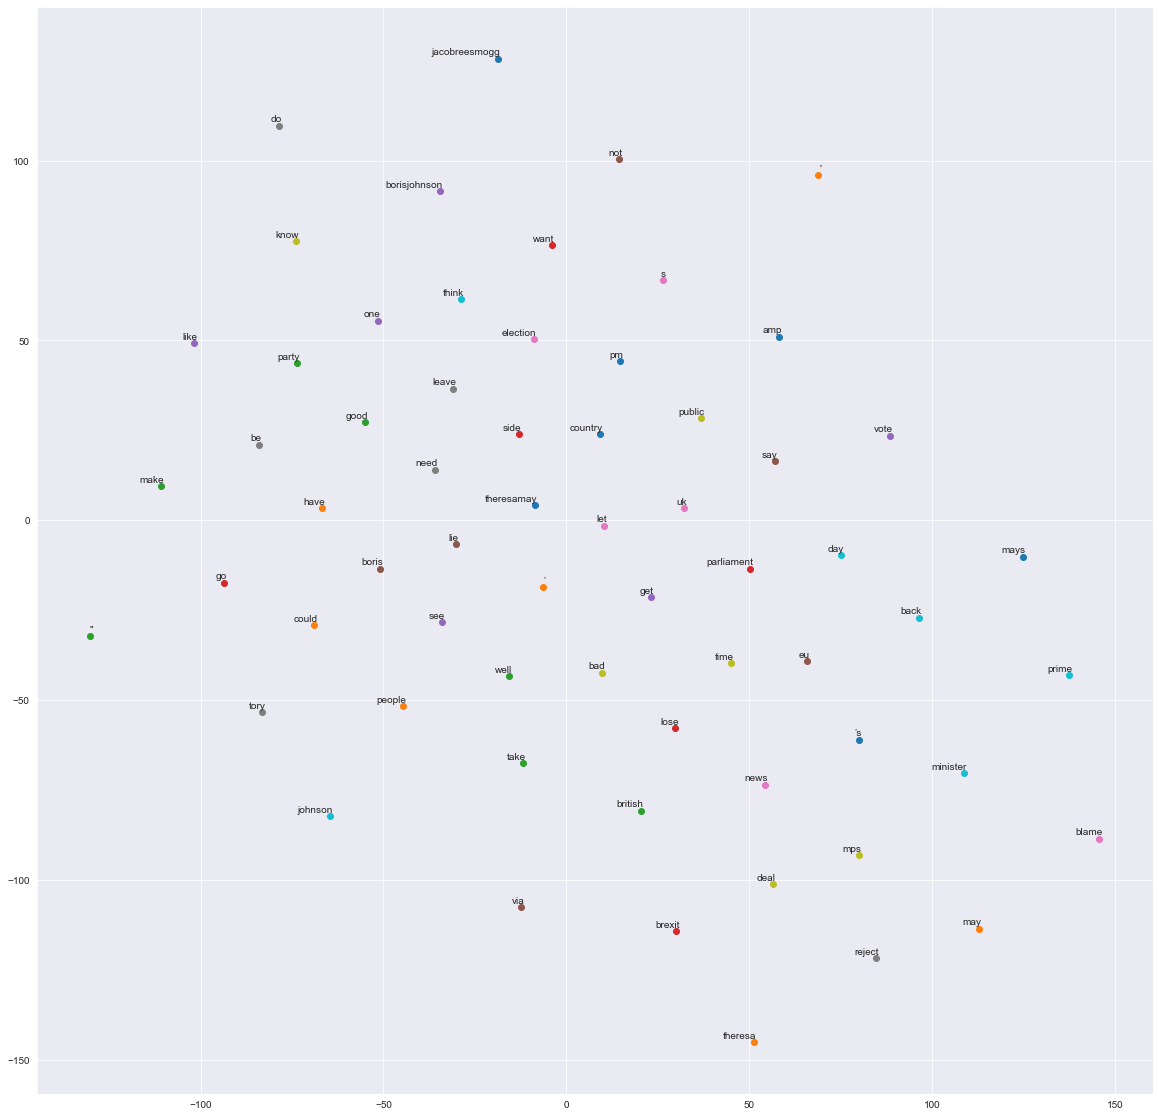

In [65]:
tsne_plot(w2v_model_march,40,5000)

#### Getting embeddings into a matrix

In [ ]:
embedding_size=100
embeddings = np.zeros((len(w2v_model.wv.index2word), embedding_size))
for i in range(0, len(w2v_model.wv.index2word)):
    w = w2v_model.wv.index2word[i]
    embeddings[i] = w2v_model.wv[w]

In [ ]:
svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=500, random_state=101)
embeddings_2d_projection = svd.fit_transform(embeddings)

#### March

In [89]:
embedding_size=200
embeddings_march = np.zeros((len(w2v_model_march.wv.index2word), embedding_size))
for i in range(0, len(w2v_model_march.wv.index2word)):
    w = w2v_model_march.wv.index2word[i]
    embeddings_march[i] = w2v_model_march.wv[w]
svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=500, random_state=101)
embeddings_2d_projection_march = svd.fit_transform(embeddings_march)

#### July

In [90]:
embedding_size=200
embeddings_july = np.zeros((len(w2v_model_july.wv.index2word), embedding_size))
for i in range(0, len(w2v_model_july.wv.index2word)):
    w = w2v_model_july.wv.index2word[i]
    embeddings_july[i] = w2v_model_july.wv[w]
svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=500, random_state=101)
embeddings_2d_projection_july = svd.fit_transform(embeddings_july)

#### Nov

In [91]:
embedding_size=200
embeddings_nov = np.zeros((len(w2v_model_nov.wv.index2word), embedding_size))
for i in range(0, len(w2v_model_nov.wv.index2word)):
    w = w2v_model_nov.wv.index2word[i]
    embeddings_nov[i] = w2v_model_nov.wv[w]
svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=500, random_state=101)
embeddings_2d_projection_nov = svd.fit_transform(embeddings_nov)

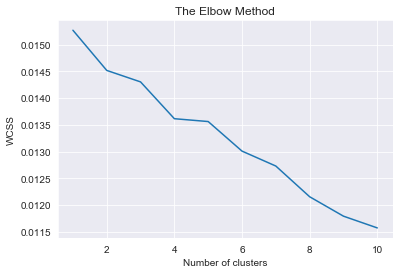

In [136]:
w = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(embeddings_nov)
    w.append(kmeans.inertia_)
plt.plot(range(1,11),w)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

### Initializing K-means

### March

In [93]:
n_clusters = 3
embedding_cluster_model_march = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings_march)

#### July

In [121]:
n_clusters = 3
embedding_cluster_model_july = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings_july)

In [125]:
n_clusters = 3
embedding_cluster_model_nov = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings_nov)

In [141]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,200), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


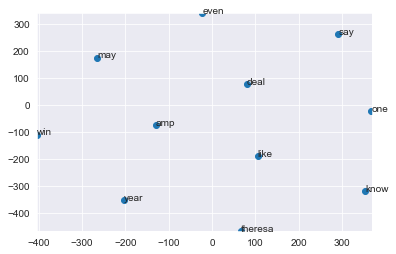

In [142]:
display_closestwords_tsnescatterplot(w2v_model_nov, 'theresa')